# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

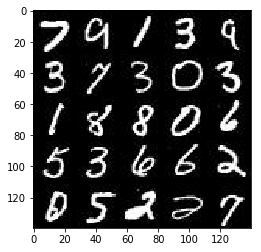

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

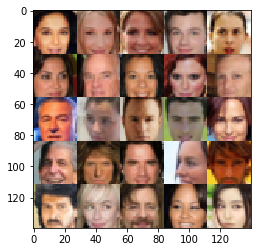

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [20]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [21]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
            
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out
    
 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [30]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [35]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [36]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_width, img_height, img_channels = data_shape
    
    real_input, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    
    d_loss, g_loss = model_loss(real_input, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                sample_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                        real_input: batch_images, input_z: sample_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={
                        input_z: sample_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: sample_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({input_z: sample_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 3.7889
Epoch 1/2... Discriminator Loss: 2.4699... Generator Loss: 1.6931
Epoch 1/2... Discriminator Loss: 0.5034... Generator Loss: 1.7825
Epoch 1/2... Discriminator Loss: 0.4652... Generator Loss: 6.1792
Epoch 1/2... Discriminator Loss: 0.0883... Generator Loss: 2.9198
Epoch 1/2... Discriminator Loss: 0.1826... Generator Loss: 3.4004
Epoch 1/2... Discriminator Loss: 0.3387... Generator Loss: 2.0741
Epoch 1/2... Discriminator Loss: 0.1774... Generator Loss: 2.5913
Epoch 1/2... Discriminator Loss: 0.1166... Generator Loss: 2.4500
Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 1.6635


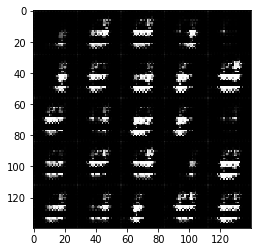

Epoch 1/2... Discriminator Loss: 0.4884... Generator Loss: 3.0051
Epoch 1/2... Discriminator Loss: 2.0319... Generator Loss: 0.3999
Epoch 1/2... Discriminator Loss: 0.6545... Generator Loss: 1.3997
Epoch 1/2... Discriminator Loss: 0.7158... Generator Loss: 1.2794
Epoch 1/2... Discriminator Loss: 1.1959... Generator Loss: 0.5647
Epoch 1/2... Discriminator Loss: 0.2487... Generator Loss: 2.6854
Epoch 1/2... Discriminator Loss: 1.7123... Generator Loss: 0.6784
Epoch 1/2... Discriminator Loss: 0.5808... Generator Loss: 2.2516
Epoch 1/2... Discriminator Loss: 0.6124... Generator Loss: 3.4636
Epoch 1/2... Discriminator Loss: 0.0827... Generator Loss: 6.1798


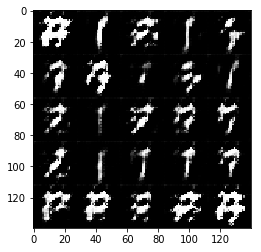

Epoch 1/2... Discriminator Loss: 0.8483... Generator Loss: 1.5577
Epoch 1/2... Discriminator Loss: 0.3159... Generator Loss: 2.2420
Epoch 1/2... Discriminator Loss: 1.7765... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 0.3126... Generator Loss: 2.6749
Epoch 1/2... Discriminator Loss: 0.4835... Generator Loss: 2.3768
Epoch 1/2... Discriminator Loss: 0.6775... Generator Loss: 2.2887
Epoch 1/2... Discriminator Loss: 2.3578... Generator Loss: 0.2149
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 3.4182
Epoch 1/2... Discriminator Loss: 0.4628... Generator Loss: 1.8902
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 4.9322


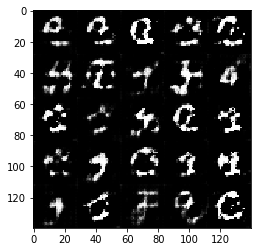

Epoch 1/2... Discriminator Loss: 0.5975... Generator Loss: 1.8240
Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 2.9664
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 2.3549
Epoch 1/2... Discriminator Loss: 0.8678... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 0.6941... Generator Loss: 1.4577
Epoch 1/2... Discriminator Loss: 0.5882... Generator Loss: 1.6168
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 0.6631
Epoch 1/2... Discriminator Loss: 0.7036... Generator Loss: 1.3897
Epoch 1/2... Discriminator Loss: 0.9039... Generator Loss: 1.1593
Epoch 1/2... Discriminator Loss: 1.0210... Generator Loss: 1.6097


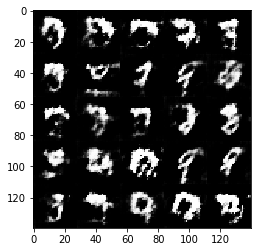

Epoch 1/2... Discriminator Loss: 0.5456... Generator Loss: 2.2728
Epoch 1/2... Discriminator Loss: 0.7658... Generator Loss: 1.0859
Epoch 1/2... Discriminator Loss: 1.4828... Generator Loss: 3.6221
Epoch 1/2... Discriminator Loss: 0.7145... Generator Loss: 1.5059
Epoch 1/2... Discriminator Loss: 0.7688... Generator Loss: 1.8181
Epoch 1/2... Discriminator Loss: 0.7815... Generator Loss: 2.2016
Epoch 1/2... Discriminator Loss: 0.8252... Generator Loss: 1.7589
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 1.5132... Generator Loss: 3.0628
Epoch 1/2... Discriminator Loss: 0.8373... Generator Loss: 1.3347


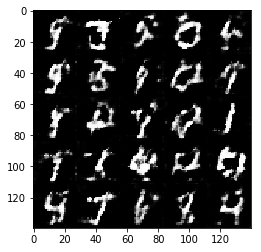

Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 0.6327
Epoch 1/2... Discriminator Loss: 0.7031... Generator Loss: 1.5398
Epoch 1/2... Discriminator Loss: 0.9933... Generator Loss: 0.7785
Epoch 1/2... Discriminator Loss: 1.0652... Generator Loss: 2.6592
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.8258
Epoch 1/2... Discriminator Loss: 1.2189... Generator Loss: 0.6448
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.6430
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 3.1892
Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 0.8224
Epoch 1/2... Discriminator Loss: 0.7683... Generator Loss: 1.5382


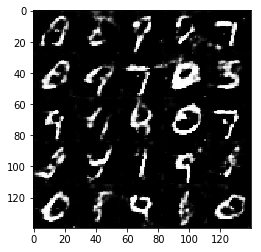

Epoch 1/2... Discriminator Loss: 0.7895... Generator Loss: 1.0619
Epoch 1/2... Discriminator Loss: 0.6394... Generator Loss: 1.3369
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 0.9362
Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 1.1030
Epoch 1/2... Discriminator Loss: 0.5413... Generator Loss: 1.5855
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 0.7270
Epoch 1/2... Discriminator Loss: 0.9966... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 0.8773... Generator Loss: 0.8949
Epoch 1/2... Discriminator Loss: 0.7027... Generator Loss: 1.0758
Epoch 1/2... Discriminator Loss: 0.6551... Generator Loss: 1.6327


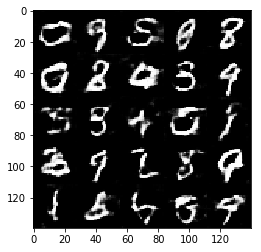

Epoch 1/2... Discriminator Loss: 1.3994... Generator Loss: 3.6013
Epoch 1/2... Discriminator Loss: 0.9764... Generator Loss: 1.0232
Epoch 1/2... Discriminator Loss: 1.1502... Generator Loss: 0.6199
Epoch 1/2... Discriminator Loss: 0.7667... Generator Loss: 0.9991
Epoch 1/2... Discriminator Loss: 0.9454... Generator Loss: 1.0743
Epoch 1/2... Discriminator Loss: 0.7728... Generator Loss: 0.9539
Epoch 1/2... Discriminator Loss: 0.8018... Generator Loss: 1.7038
Epoch 1/2... Discriminator Loss: 0.7207... Generator Loss: 1.2188
Epoch 1/2... Discriminator Loss: 1.3577... Generator Loss: 0.4796
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 0.9270


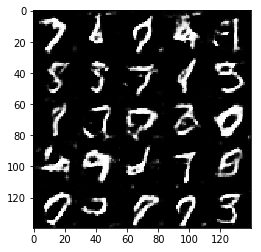

Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 1.2494
Epoch 1/2... Discriminator Loss: 0.8295... Generator Loss: 1.4152
Epoch 1/2... Discriminator Loss: 2.0101... Generator Loss: 0.2236
Epoch 1/2... Discriminator Loss: 1.0610... Generator Loss: 0.7710
Epoch 1/2... Discriminator Loss: 0.9475... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 1.8078... Generator Loss: 1.6914
Epoch 1/2... Discriminator Loss: 0.6893... Generator Loss: 1.4344
Epoch 1/2... Discriminator Loss: 0.5937... Generator Loss: 1.8458
Epoch 1/2... Discriminator Loss: 0.9471... Generator Loss: 0.7522
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 0.8213


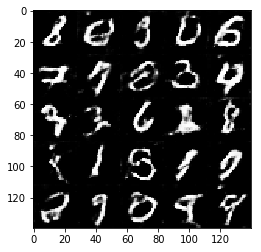

Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 2.2036
Epoch 1/2... Discriminator Loss: 0.7515... Generator Loss: 1.1103
Epoch 1/2... Discriminator Loss: 0.9140... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 1.0293
Epoch 2/2... Discriminator Loss: 1.1116... Generator Loss: 0.6336
Epoch 2/2... Discriminator Loss: 0.7180... Generator Loss: 2.2839
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 2.6815
Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 0.8210
Epoch 2/2... Discriminator Loss: 0.9104... Generator Loss: 0.9647
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 1.9108


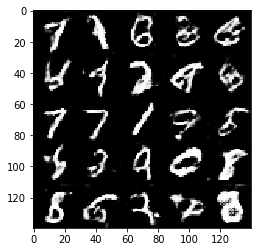

Epoch 2/2... Discriminator Loss: 1.1306... Generator Loss: 0.5398
Epoch 2/2... Discriminator Loss: 2.2813... Generator Loss: 0.1831
Epoch 2/2... Discriminator Loss: 1.2414... Generator Loss: 0.6133
Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 0.3558
Epoch 2/2... Discriminator Loss: 1.6041... Generator Loss: 0.3667
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 0.9297
Epoch 2/2... Discriminator Loss: 1.3163... Generator Loss: 2.4229
Epoch 2/2... Discriminator Loss: 1.0519... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.5580
Epoch 2/2... Discriminator Loss: 0.9333... Generator Loss: 2.0904


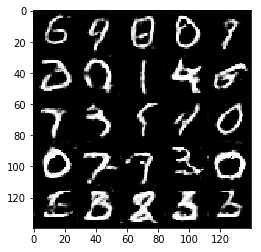

Epoch 2/2... Discriminator Loss: 0.9244... Generator Loss: 1.0188
Epoch 2/2... Discriminator Loss: 1.4454... Generator Loss: 0.3650
Epoch 2/2... Discriminator Loss: 1.1698... Generator Loss: 0.5038
Epoch 2/2... Discriminator Loss: 1.3917... Generator Loss: 0.4741
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 0.8278
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 2.3253
Epoch 2/2... Discriminator Loss: 0.8213... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 0.7997... Generator Loss: 1.1483
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.4789
Epoch 2/2... Discriminator Loss: 1.4612... Generator Loss: 0.4112


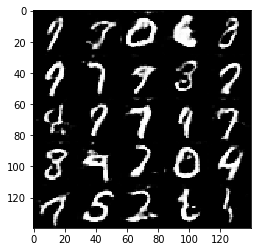

Epoch 2/2... Discriminator Loss: 0.6472... Generator Loss: 1.6193
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 1.8993
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.4865
Epoch 2/2... Discriminator Loss: 1.1317... Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 2.5851... Generator Loss: 4.3462
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 1.5039
Epoch 2/2... Discriminator Loss: 1.4200... Generator Loss: 2.5064
Epoch 2/2... Discriminator Loss: 0.7948... Generator Loss: 0.9804
Epoch 2/2... Discriminator Loss: 0.7109... Generator Loss: 1.4436
Epoch 2/2... Discriminator Loss: 0.4878... Generator Loss: 1.5205


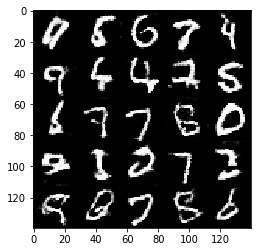

Epoch 2/2... Discriminator Loss: 1.5387... Generator Loss: 0.3982
Epoch 2/2... Discriminator Loss: 1.0025... Generator Loss: 1.9862
Epoch 2/2... Discriminator Loss: 1.2677... Generator Loss: 0.4824
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 1.6332
Epoch 2/2... Discriminator Loss: 0.9748... Generator Loss: 0.9366
Epoch 2/2... Discriminator Loss: 1.1978... Generator Loss: 0.6076
Epoch 2/2... Discriminator Loss: 1.9431... Generator Loss: 0.2882
Epoch 2/2... Discriminator Loss: 0.5661... Generator Loss: 1.4110
Epoch 2/2... Discriminator Loss: 2.1855... Generator Loss: 0.1882
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 0.6524


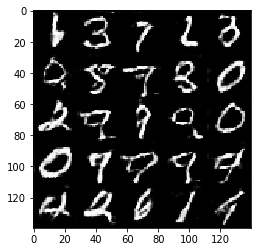

Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 1.1262
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 0.8685
Epoch 2/2... Discriminator Loss: 0.8166... Generator Loss: 1.4633
Epoch 2/2... Discriminator Loss: 1.5278... Generator Loss: 0.3664
Epoch 2/2... Discriminator Loss: 0.9870... Generator Loss: 0.8202
Epoch 2/2... Discriminator Loss: 0.9083... Generator Loss: 0.8632
Epoch 2/2... Discriminator Loss: 1.4050... Generator Loss: 0.4203
Epoch 2/2... Discriminator Loss: 1.4673... Generator Loss: 3.3682
Epoch 2/2... Discriminator Loss: 1.6280... Generator Loss: 0.3082
Epoch 2/2... Discriminator Loss: 0.9911... Generator Loss: 0.9057


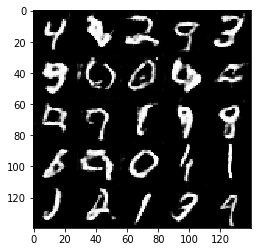

Epoch 2/2... Discriminator Loss: 1.1265... Generator Loss: 0.7488
Epoch 2/2... Discriminator Loss: 0.7766... Generator Loss: 1.7451
Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 1.1008
Epoch 2/2... Discriminator Loss: 2.1259... Generator Loss: 0.2416
Epoch 2/2... Discriminator Loss: 0.8885... Generator Loss: 1.3436
Epoch 2/2... Discriminator Loss: 1.0549... Generator Loss: 0.7046
Epoch 2/2... Discriminator Loss: 0.7244... Generator Loss: 1.0851
Epoch 2/2... Discriminator Loss: 0.5968... Generator Loss: 1.0805
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 3.3600
Epoch 2/2... Discriminator Loss: 0.9781... Generator Loss: 0.9660


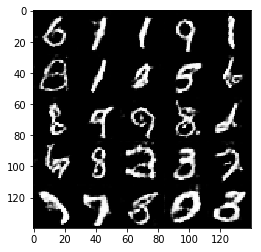

Epoch 2/2... Discriminator Loss: 1.1594... Generator Loss: 2.5942
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 0.5106... Generator Loss: 1.3764
Epoch 2/2... Discriminator Loss: 0.4804... Generator Loss: 1.7966
Epoch 2/2... Discriminator Loss: 1.0280... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 0.8964
Epoch 2/2... Discriminator Loss: 1.4672... Generator Loss: 0.4534
Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.5246
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 0.9318... Generator Loss: 1.0940


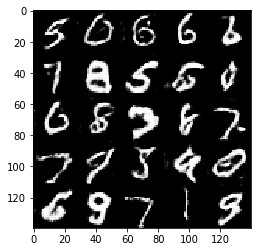

Epoch 2/2... Discriminator Loss: 0.7720... Generator Loss: 1.3406
Epoch 2/2... Discriminator Loss: 1.0100... Generator Loss: 0.6549
Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 0.6165
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 1.5482
Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 3.0814
Epoch 2/2... Discriminator Loss: 0.8543... Generator Loss: 1.2636
Epoch 2/2... Discriminator Loss: 0.5696... Generator Loss: 1.6750
Epoch 2/2... Discriminator Loss: 1.5069... Generator Loss: 0.6691
Epoch 2/2... Discriminator Loss: 1.6929... Generator Loss: 0.4577


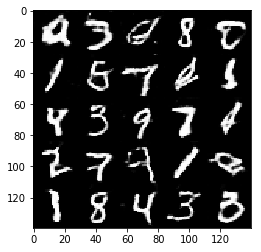

Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.4388
Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 0.7276
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 1.6199
Epoch 2/2... Discriminator Loss: 0.9492... Generator Loss: 0.7782
Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 1.7800
Epoch 2/2... Discriminator Loss: 1.2202... Generator Loss: 0.7054
Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 1.9513


In [38]:
batch_size = 64
z_dim = 100
learning_rate = .002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.0684... Generator Loss: 0.4099
Epoch 1/1... Discriminator Loss: 0.0928... Generator Loss: 9.8823
Epoch 1/1... Discriminator Loss: 0.5003... Generator Loss: 7.2885
Epoch 1/1... Discriminator Loss: 0.2018... Generator Loss: 8.9499
Epoch 1/1... Discriminator Loss: 3.3522... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 4.6782... Generator Loss: 0.0430
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.9068
Epoch 1/1... Discriminator Loss: 0.2396... Generator Loss: 6.2360
Epoch 1/1... Discriminator Loss: 3.0338... Generator Loss: 0.1355
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.5846


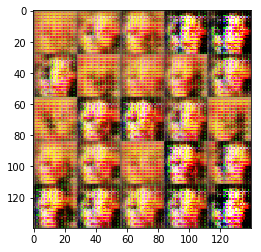

Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 5.9175
Epoch 1/1... Discriminator Loss: 0.2282... Generator Loss: 4.3050
Epoch 1/1... Discriminator Loss: 0.2574... Generator Loss: 5.1719
Epoch 1/1... Discriminator Loss: 0.6187... Generator Loss: 1.0464
Epoch 1/1... Discriminator Loss: 0.2243... Generator Loss: 3.3741
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 7.8106
Epoch 1/1... Discriminator Loss: 0.2766... Generator Loss: 2.2722
Epoch 1/1... Discriminator Loss: 0.2800... Generator Loss: 2.9977
Epoch 1/1... Discriminator Loss: 1.9934... Generator Loss: 0.2879


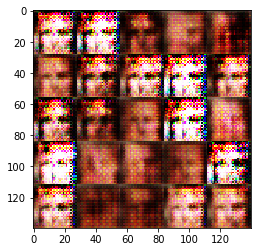

Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 1.4313
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 1.7467
Epoch 1/1... Discriminator Loss: 0.3314... Generator Loss: 1.7058
Epoch 1/1... Discriminator Loss: 0.4918... Generator Loss: 2.2843
Epoch 1/1... Discriminator Loss: 0.6165... Generator Loss: 0.9767
Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.6649... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.4995
Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.7224


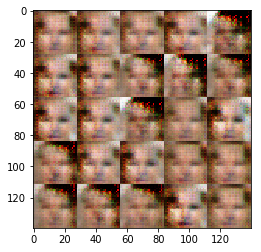

Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 3.4240
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.3856
Epoch 1/1... Discriminator Loss: 0.6404... Generator Loss: 2.0916
Epoch 1/1... Discriminator Loss: 0.5173... Generator Loss: 1.8817
Epoch 1/1... Discriminator Loss: 0.7254... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.5103
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 0.7222... Generator Loss: 1.6114
Epoch 1/1... Discriminator Loss: 1.9132... Generator Loss: 3.4111
Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 1.0337


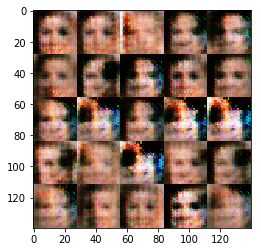

Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.2715
Epoch 1/1... Discriminator Loss: 1.5325... Generator Loss: 0.3870
Epoch 1/1... Discriminator Loss: 0.7723... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 1.7668
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.3234
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.5603


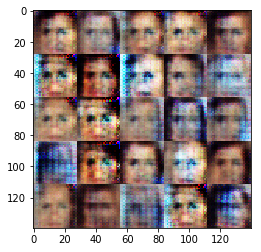

Epoch 1/1... Discriminator Loss: 1.5500... Generator Loss: 0.5030
Epoch 1/1... Discriminator Loss: 2.7790... Generator Loss: 3.9445
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.8752
Epoch 1/1... Discriminator Loss: 2.2268... Generator Loss: 2.7759
Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 1.8708
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.5842... Generator Loss: 0.4170
Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.2574


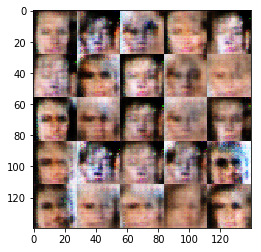

Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.6583
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 2.4975
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 0.8601... Generator Loss: 1.1161
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.0796
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 0.8600


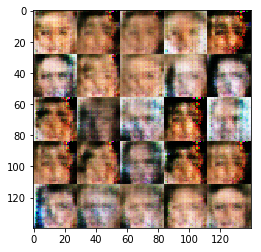

Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.2915
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 1.7875
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 2.0668
Epoch 1/1... Discriminator Loss: 0.7951... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 1.4281
Epoch 1/1... Discriminator Loss: 0.7286... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.2810
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 2.1540
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.0775


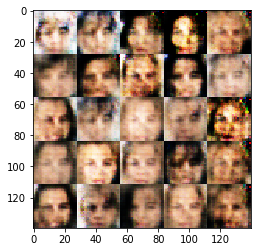

Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 1.4712
Epoch 1/1... Discriminator Loss: 0.9206... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 0.8436... Generator Loss: 1.2597
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.5387
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.7064... Generator Loss: 2.9349


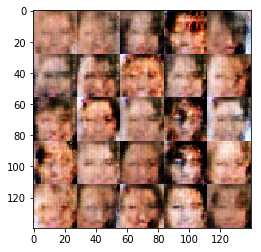

Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 1.0162
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 0.7911... Generator Loss: 1.9900
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.5568
Epoch 1/1... Discriminator Loss: 1.6404... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 2.1358
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.6394... Generator Loss: 0.3645
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.6791


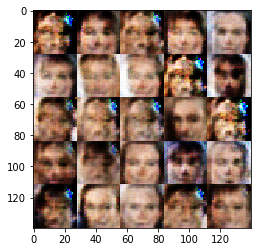

Epoch 1/1... Discriminator Loss: 0.7225... Generator Loss: 1.2944
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 1.9534
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 2.0081
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.4810
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 1.3356
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6515


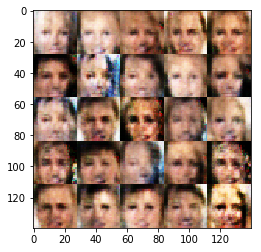

Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 1.8440
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.5142
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.9425
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 2.9251
Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 0.9762
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.7829


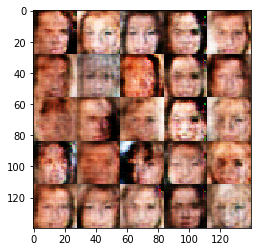

Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.2127
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 2.1257
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.3113
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.2177
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 1.1735
Epoch 1/1... Discriminator Loss: 0.7034... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.0277... Generator Loss: 1.4803
Epoch 1/1... Discriminator Loss: 0.9519... Generator Loss: 1.3481
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 0.8701


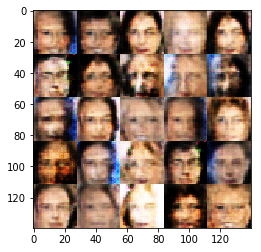

Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 1.9815
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.8770
Epoch 1/1... Discriminator Loss: 1.5763... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 0.5835... Generator Loss: 1.4247
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.5156
Epoch 1/1... Discriminator Loss: 2.9622... Generator Loss: 2.7072
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.9696


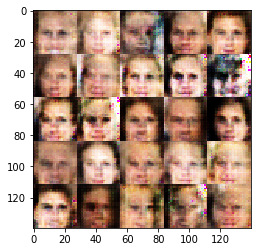

Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.1084... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.3709
Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 1.0803
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.0112... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 1.1914
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.7503


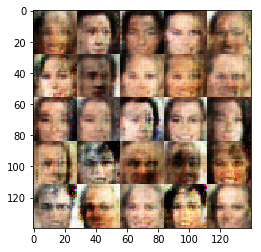

Epoch 1/1... Discriminator Loss: 1.0469... Generator Loss: 1.0957
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.8947
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7414


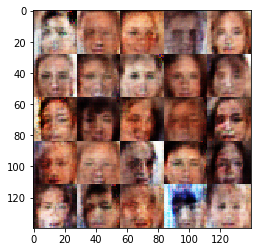

Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 2.5133
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.7475
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.4525
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 0.8437... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 2.1049
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 2.0314
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.5397


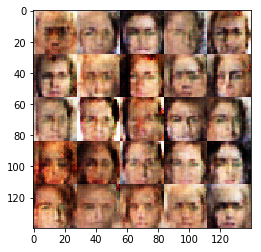

Epoch 1/1... Discriminator Loss: 1.5055... Generator Loss: 1.1847
Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 1.5890
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.1446
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 0.3510
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.1136... Generator Loss: 0.7006


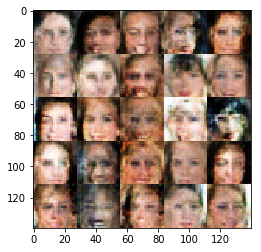

Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.4200
Epoch 1/1... Discriminator Loss: 0.9543... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.3929
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.8989
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.0984... Generator Loss: 1.9293
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.5933


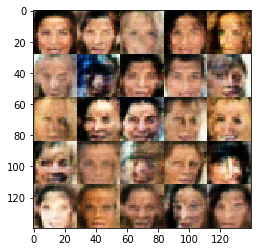

Epoch 1/1... Discriminator Loss: 1.6585... Generator Loss: 0.3749
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9367
Epoch 1/1... Discriminator Loss: 1.1124... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.4011
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.5173
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.5566


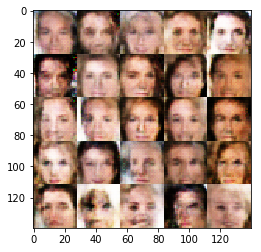

Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 1.6134
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.5545
Epoch 1/1... Discriminator Loss: 0.8627... Generator Loss: 1.0042
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 1.9605
Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 2.3886... Generator Loss: 0.1573
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 1.1687
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 1.8229


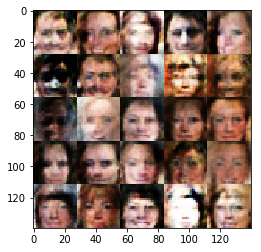

Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.9724
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.7968... Generator Loss: 0.3423
Epoch 1/1... Discriminator Loss: 1.1456... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.3409
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.9982


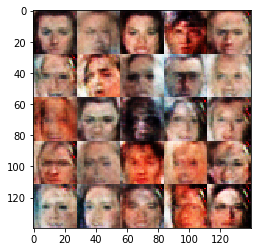

Epoch 1/1... Discriminator Loss: 0.8032... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 0.9106... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.1017... Generator Loss: 1.2565
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.0505... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 1.0286
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.0639
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.9071


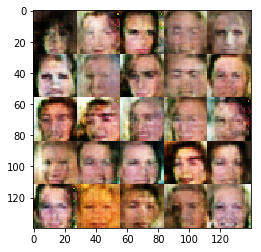

Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.6844... Generator Loss: 2.2475
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 1.2686
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.4222
Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.0243
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.7401


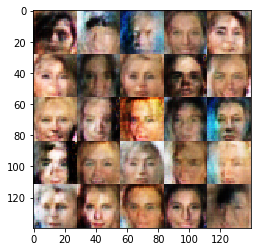

Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.3506
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.3901
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 1.4039
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 2.1484
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 0.9552
Epoch 1/1... Discriminator Loss: 2.5062... Generator Loss: 4.4259


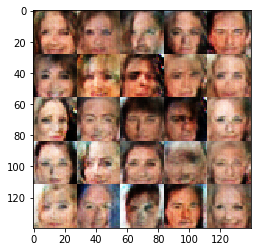

Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 2.3841
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.2401
Epoch 1/1... Discriminator Loss: 1.0845... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.4488
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 1.9985
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 0.7059


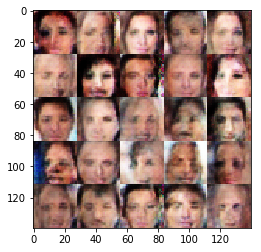

Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 0.9537... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 1.5980... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.3995
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 0.4686... Generator Loss: 2.2793
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 1.9695
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 1.0372
Epoch 1/1... Discriminator Loss: 1.0991... Generator Loss: 2.0276


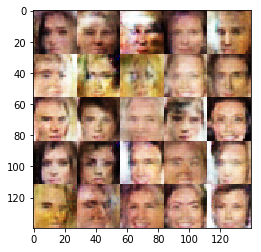

Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 0.9352... Generator Loss: 1.3050
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.4050
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.8393
Epoch 1/1... Discriminator Loss: 1.6560... Generator Loss: 0.3227
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.5741... Generator Loss: 0.3434
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.9711


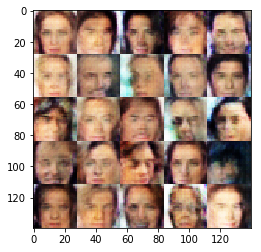

Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.3933
Epoch 1/1... Discriminator Loss: 0.9103... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.3743
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.6385
Epoch 1/1... Discriminator Loss: 1.0956... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.3374
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 0.9834


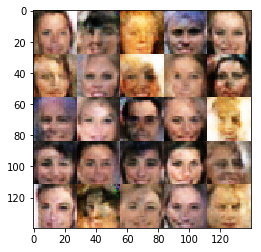

Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.5172
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 1.9089
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.3365
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 1.3015
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.5232


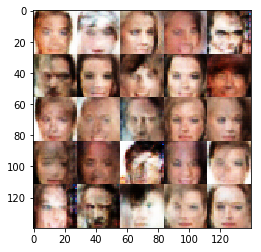

Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.3151
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 1.8794
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8540


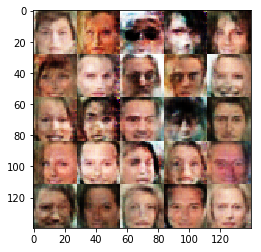

Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 1.5284
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.1039... Generator Loss: 0.7302


In [39]:
batch_size = 64
z_dim = 100
learning_rate = .002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.